In [1]:
import math
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def bar_chart(ax, algorithms, normalize_by=None):
    names = [x['algorithm']['name'] for x in algorithms]
    expected_results = [x.get('expected_makespan') for x in algorithms]
    actual_results = [x['makespan'] for x in algorithms]
    if normalize_by:
        actual_results = [x/normalize_by for x in actual_results]
        expected_results = [x/normalize_by for x in expected_results]
        plt.plot([-0.5, len(names)-0.5], [1, 1], color='#C44E52', linewidth=4)
    for i, (expected, actual) in enumerate(zip(expected_results, actual_results)):
        if not math.isnan(expected):
            ax.add_patch(Rectangle((-0.4+i, 0), 0.38, expected, color='#55A868'))
            ax.add_patch(Rectangle(( 0.02 +i, 0), 0.38, actual, color='#4C72B0'))
        else:
            ax.add_patch(Rectangle((-0.4+i, 0), 0.8, actual, color='#4C72B0'))
    plt.xlim(-0.5, len(names)-0.5)
    plt.xticks(range(len(names)), names)

In [2]:
def groupby(values, key, apply=None):
    grouped = {}
    for x in values:
        grouped.setdefault(key(x), [])
        grouped[key(x)].append(x)
    if apply:
        for k in grouped:
            grouped[k] = apply(grouped[k])
    return grouped

In [3]:
def get_name_by_path(path):
    return path.split("/")[-1].rsplit('.', 1)[0]

def platform_sort_key(item):
    return platform_order.index(get_name_by_path(item[0]))

platform_order = ['simple_3', 'simple_6', 'platform_host', 'platform_rack', 'platform_cluster']

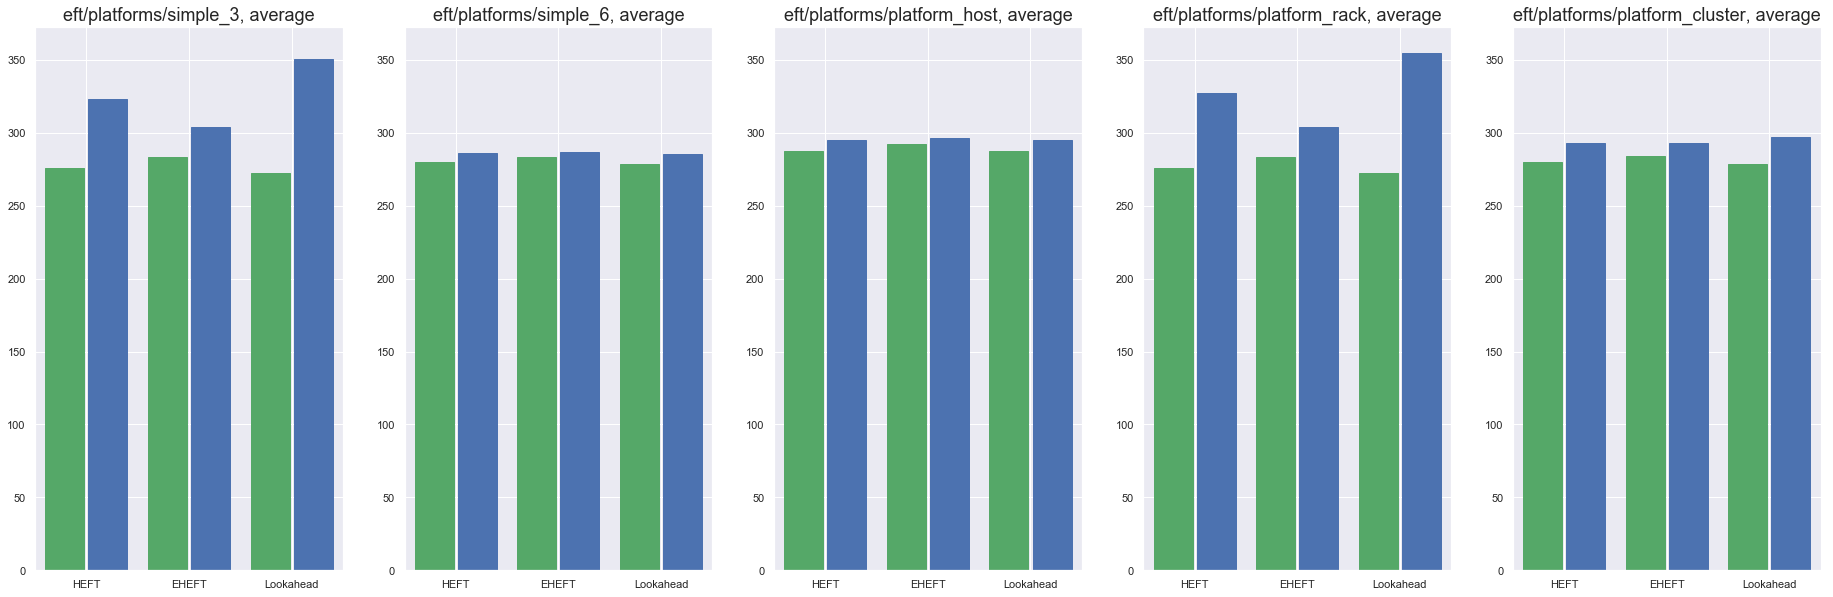

In [4]:
import json
results = json.load(open('output'))
results = [x for x in results if '../thesis/experiment-3/platforms/platforms/' not in x['platform']]
for x in results:
    x['tasks'] = x['tasks'][len('../thesis/experiment-3/workflows/'):][:-len('.dot')]
    x['platform'] = x['platform'][len('../thesis/experiment-3/platforms/'):][:-len('.xml')]
    
def mean_fn(value):
    return {
        'expected_makespan': sum([x['expected_makespan'] for x in value]) / len(value),
        'makespan': sum([x['makespan'] for x in value]) / len(value),
        'algorithm': {'name': value[0]['algorithm']['name']},
        'platform': value[0]['platform'],
        'tasks': 'average',
    }
mean = groupby(results, key=lambda r:(r['platform'], r['algorithm']['name']), apply=mean_fn)
results = list(mean.values())

by_platform_and_worflow = {}
for r in results:
    if 'simple_' in r['tasks']:
        continue
    by_platform_and_worflow.setdefault(r['tasks'], {})
    by_platform_and_worflow[r['tasks']].setdefault(r['platform'], [])
    by_platform_and_worflow[r['tasks']][r['platform']].append(r)

plt.figure(figsize=(32, 10))
counter = 1
for i, (workflow, workflow_results) in enumerate(sorted(by_platform_and_worflow.items())):
    max_res = 0
    for platform_results in workflow_results.values():
        expected = [x['expected_makespan'] for x in platform_results if not math.isnan(x['expected_makespan'])] or [max_res]
        max_res = max(
             max_res,
             max([x['makespan'] for x in platform_results]),
             max(expected)
         )
    for j, (platform, platform_results) in enumerate(sorted(workflow_results.items(), key=platform_sort_key)):
        ax = plt.subplot(len(by_platform_and_worflow), len(workflow_results), counter)
        plt.ylim(top=max_res*1.05)
        bar_chart(ax, platform_results)
        plt.title(f'{platform}, {workflow}', fontsize=18)
        counter += 1
plt.savefig('charts.png')

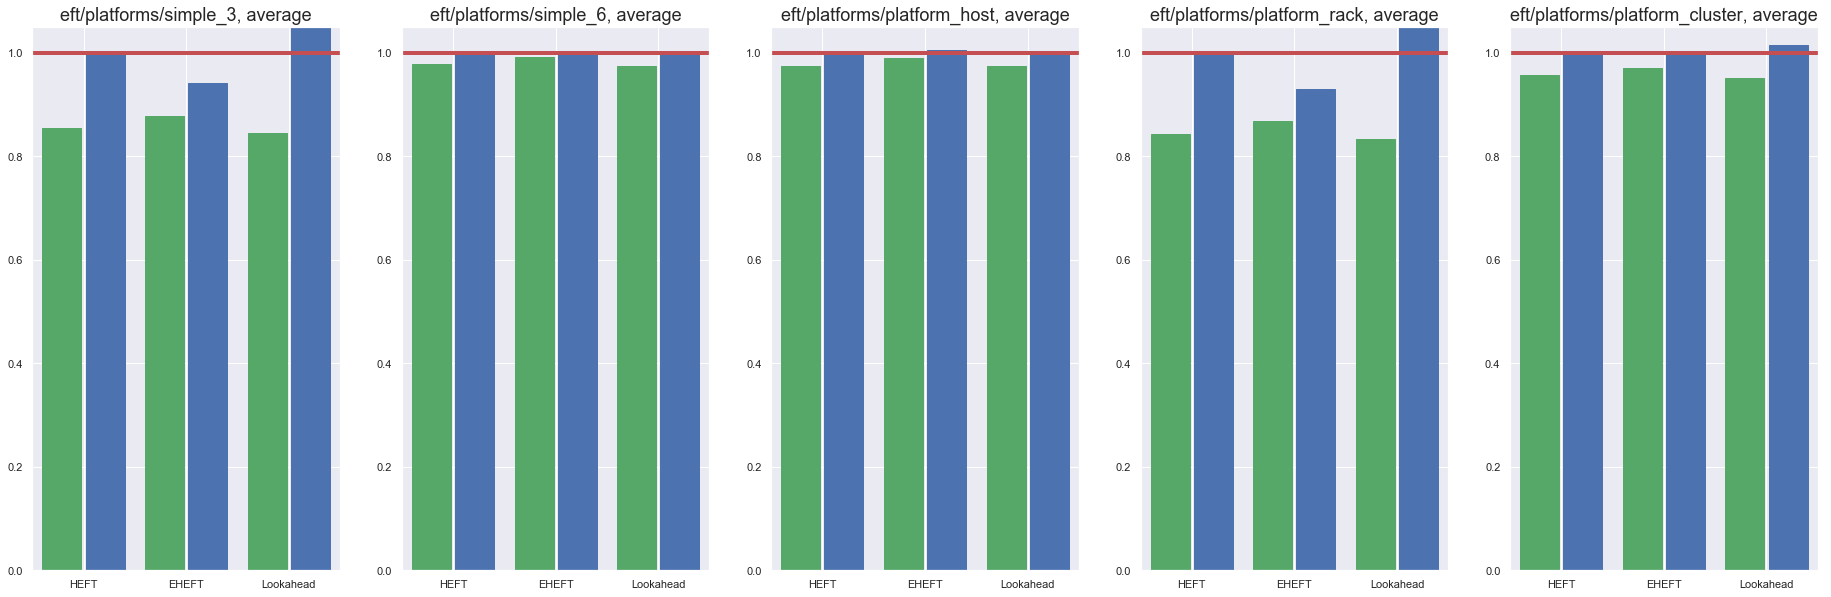

In [5]:
import json
results = json.load(open('output'))
results = [x for x in results if '../thesis/experiment-3/platforms/platforms/' not in x['platform']]
for x in results:
    x['tasks'] = x['tasks'][len('../thesis/experiment-3/workflows/'):][:-len('.dot')]
    x['platform'] = x['platform'][len('../thesis/experiment-3/platforms/'):][:-len('.xml')]
    
def mean_fn(value):
    return {
        'expected_makespan': sum([x['expected_makespan'] for x in value]) / len(value),
        'makespan': sum([x['makespan'] for x in value]) / len(value),
        'algorithm': {'name': value[0]['algorithm']['name']},
        'platform': value[0]['platform'],
        'tasks': 'average',
    }
mean = groupby(results, key=lambda r:(r['platform'], r['algorithm']['name']), apply=mean_fn)
results = list(mean.values())

by_platform_and_worflow = {}
for r in results:
    if 'simple_' in r['tasks']:
        continue
    by_platform_and_worflow.setdefault(r['tasks'], {})
    by_platform_and_worflow[r['tasks']].setdefault(r['platform'], [])
    by_platform_and_worflow[r['tasks']][r['platform']].append(r)

plt.figure(figsize=(32, 10))
counter = 1
for i, (workflow, workflow_results) in enumerate(sorted(by_platform_and_worflow.items())):
    max_res = 0
    for platform_results in workflow_results.values():
         max_res = max(max_res, max([x['makespan'] for x in platform_results]))
    for j, (platform, platform_results) in enumerate(sorted(workflow_results.items(), key=platform_sort_key)):
        ax = plt.subplot(len(by_platform_and_worflow), len(workflow_results), counter)
        baseline = platform_results[0]['makespan']
        plt.ylim(top=1.05)
        bar_chart(ax, platform_results, normalize_by=baseline)
#         platform = platform.split("/")[-1].rsplit('.', 1)[0]
#         workflow = workflow.split("/")[-1].rsplit('.', 1)[0]
        plt.title(f'{platform}, {workflow}', fontsize=18)
        counter += 1
plt.savefig('charts_percentage.png')

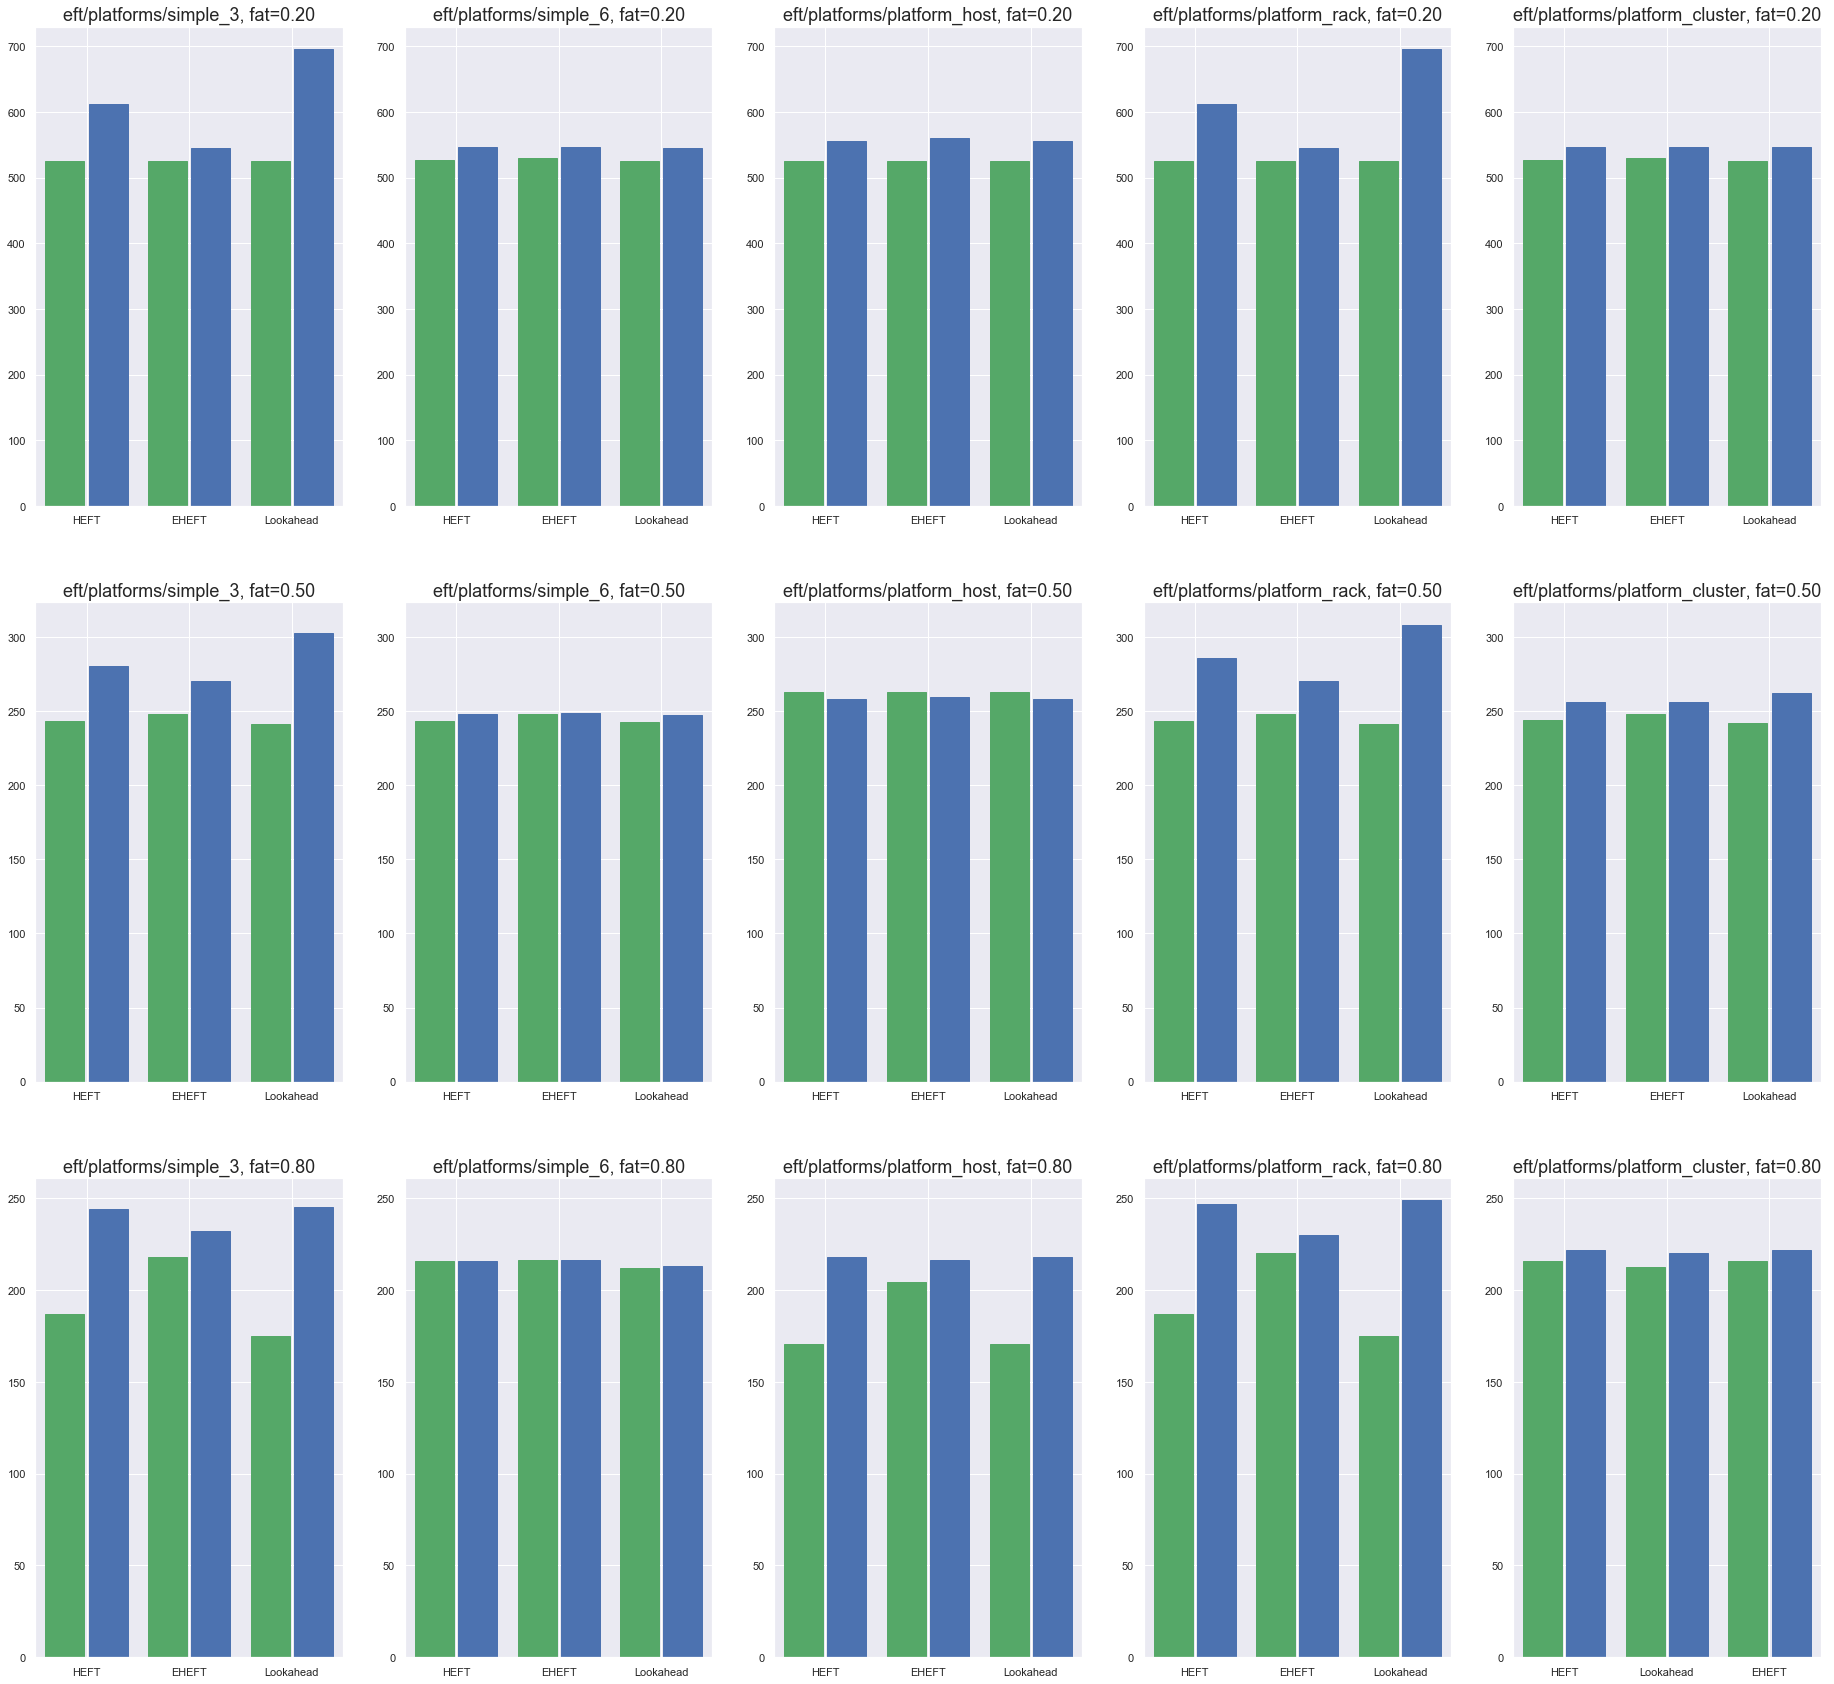

In [6]:
def groupby_value(results, value_num):
    def fn(x):
        return (x['platform'], x['algorithm']['name'], x['tasks'].split('_')[value_num])
    def mean_fn(value):
        return {
            'expected_makespan': sum([x['expected_makespan'] for x in value]) / len(value),
            'makespan': sum([x['makespan'] for x in value]) / len(value),
            'algorithm': {'name': value[0]['algorithm']['name']},
            'platform': value[0]['platform'],
            'tasks': value[0]['tasks'].split('_')[value_num],
        }
    return groupby(results, fn, mean_fn)


import json
results = json.load(open('output'))
results = [x for x in results if '../thesis/experiment-3/platforms/platforms/' not in x['platform']]
for x in results:
    x['tasks'] = x['tasks'][len('../thesis/experiment-3/workflows/'):][:-len('.dot')]
    x['platform'] = x['platform'][len('../thesis/experiment-3/platforms/'):][:-len('.xml')]
    
mean = groupby_value(results, 2)
results = list(mean.values())

by_platform_and_worflow = {}
for r in results:
    if 'simple_' in r['tasks']:
        continue
    by_platform_and_worflow.setdefault(r['tasks'], {})
    by_platform_and_worflow[r['tasks']].setdefault(r['platform'], [])
    by_platform_and_worflow[r['tasks']][r['platform']].append(r)

plt.figure(figsize=(32, 30))
counter = 1
for i, (workflow, workflow_results) in enumerate(sorted(by_platform_and_worflow.items())):
    max_res = 0
    for platform_results in workflow_results.values():
        expected = [x['expected_makespan'] for x in platform_results if not math.isnan(x['expected_makespan'])] or [max_res]
        max_res = max(
             max_res,
             max([x['makespan'] for x in platform_results]),
             max(expected)
         )
    for j, (platform, platform_results) in enumerate(sorted(workflow_results.items(), key=platform_sort_key)):
        ax = plt.subplot(len(by_platform_and_worflow), len(workflow_results), counter)
        plt.ylim(top=max_res*1.05)
        bar_chart(ax, platform_results)
        plt.title(f'{platform}, fat={workflow}', fontsize=18)
        counter += 1
plt.savefig('charts.png')

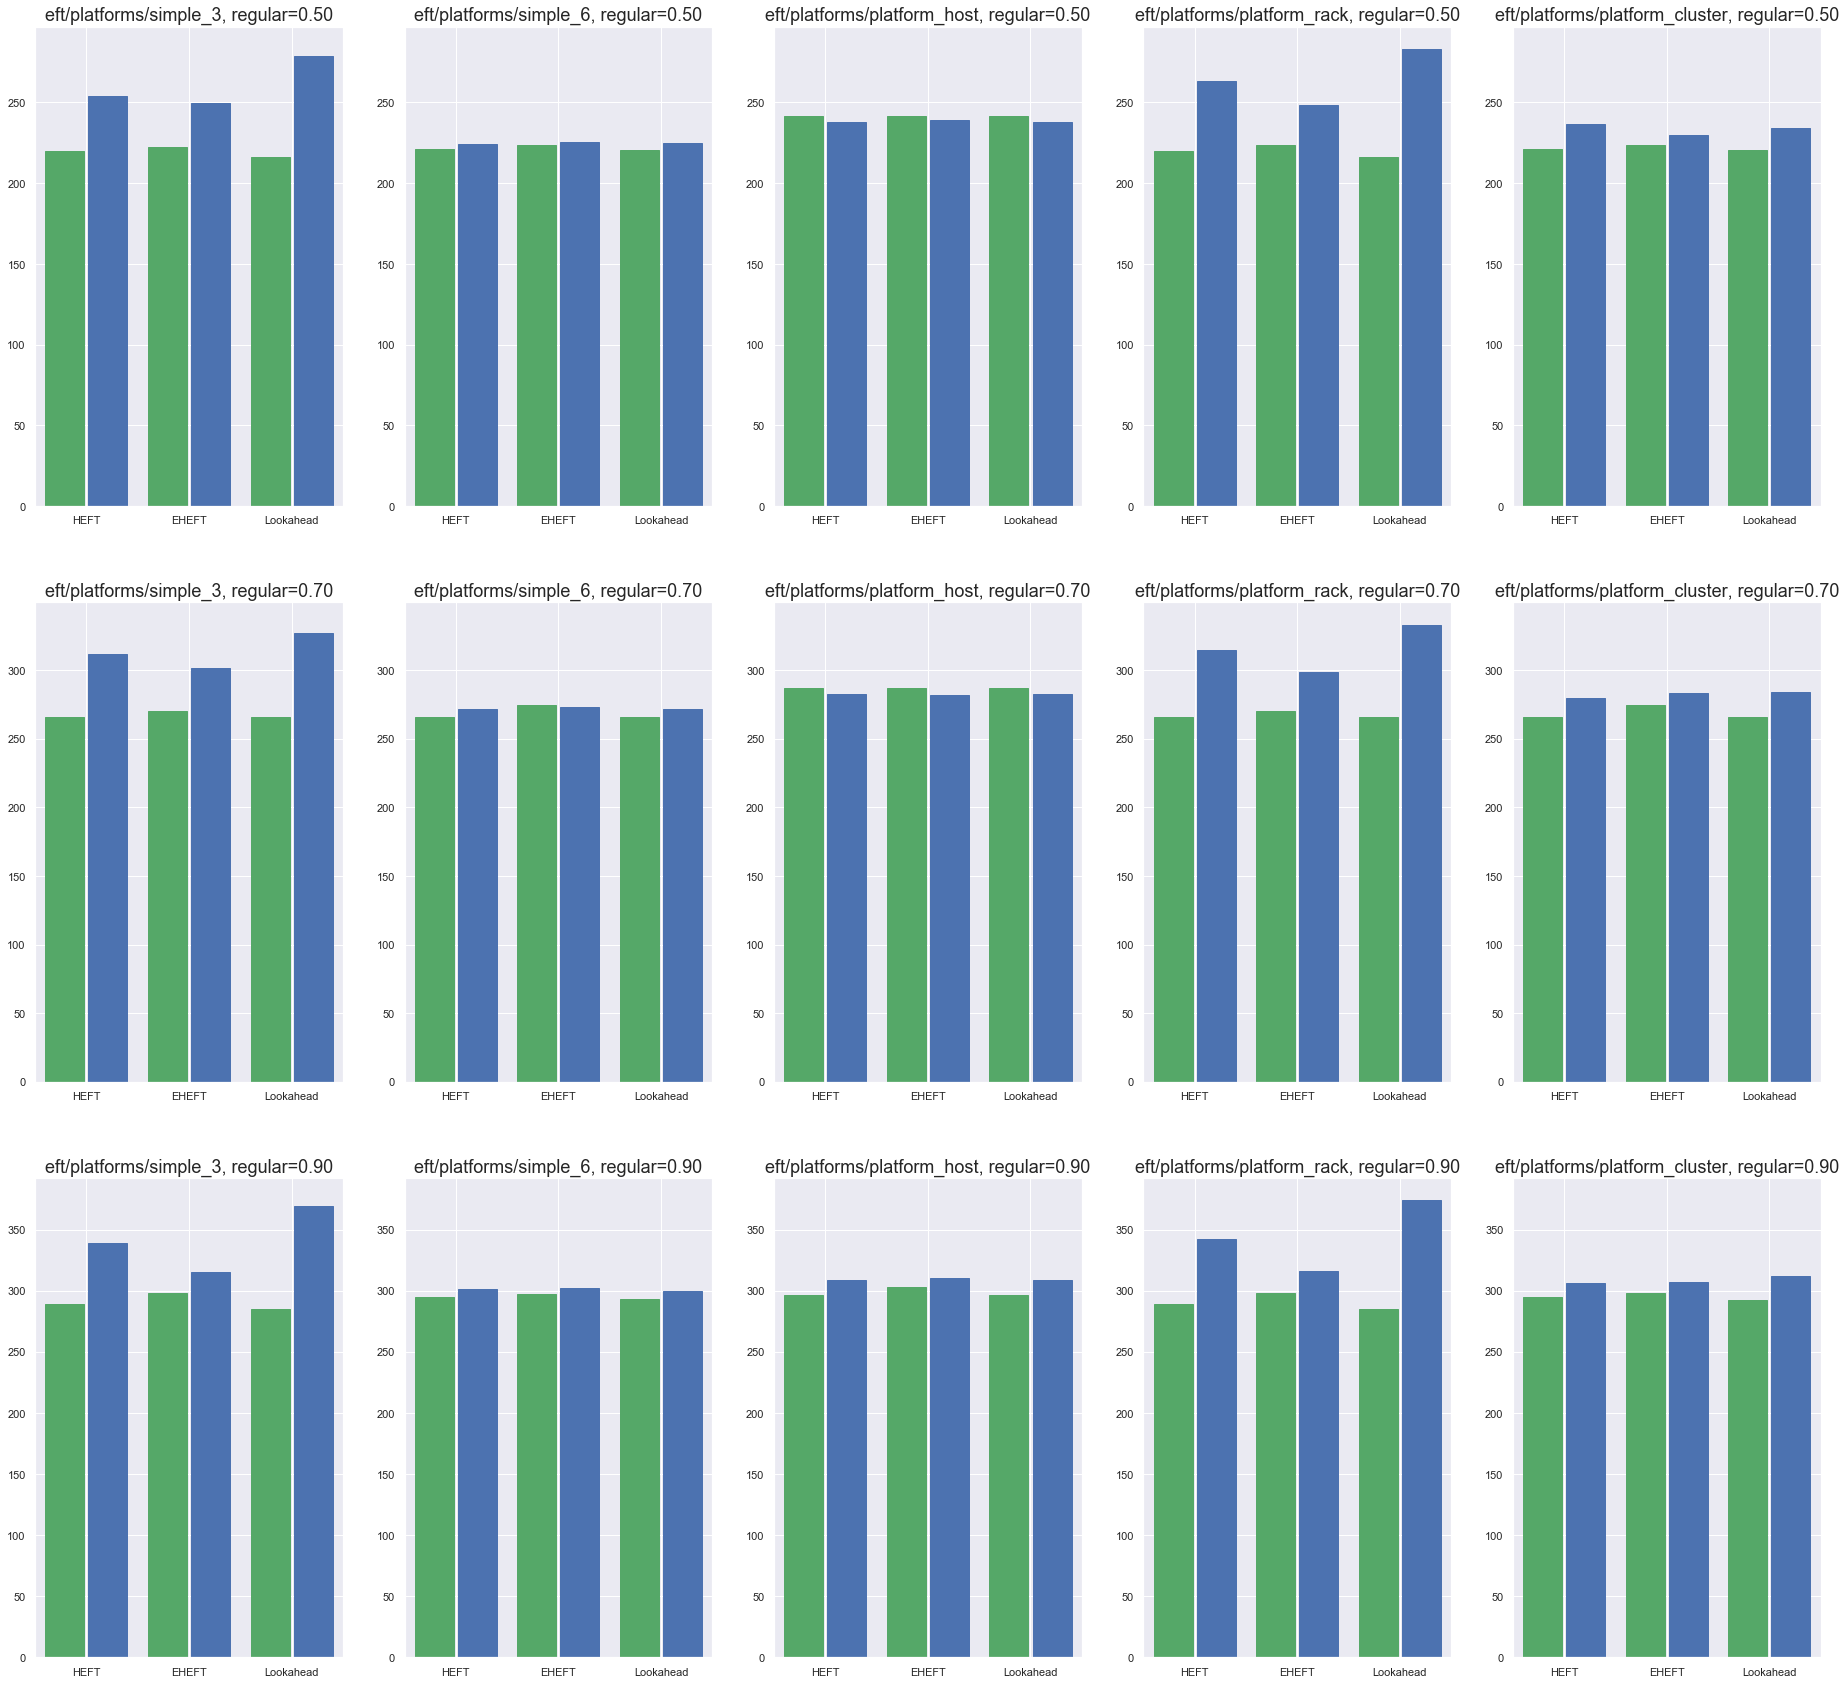

In [7]:
import json
results = json.load(open('output'))
results = [x for x in results if '../thesis/experiment-3/platforms/platforms/' not in x['platform']]
for x in results:
    x['tasks'] = x['tasks'][len('../thesis/experiment-3/workflows/'):][:-len('.dot')]
    x['platform'] = x['platform'][len('../thesis/experiment-3/platforms/'):][:-len('.xml')]
    
mean = groupby_value(results, 3)
results = list(mean.values())

by_platform_and_worflow = {}
for r in results:
    if 'simple_' in r['tasks']:
        continue
    by_platform_and_worflow.setdefault(r['tasks'], {})
    by_platform_and_worflow[r['tasks']].setdefault(r['platform'], [])
    by_platform_and_worflow[r['tasks']][r['platform']].append(r)

plt.figure(figsize=(32, 30))
counter = 1
for i, (workflow, workflow_results) in enumerate(sorted(by_platform_and_worflow.items())):
    max_res = 0
    for platform_results in workflow_results.values():
        expected = [x['expected_makespan'] for x in platform_results if not math.isnan(x['expected_makespan'])] or [max_res]
        max_res = max(
             max_res,
             max([x['makespan'] for x in platform_results]),
             max(expected)
         )
    for j, (platform, platform_results) in enumerate(sorted(workflow_results.items(), key=platform_sort_key)):
        ax = plt.subplot(len(by_platform_and_worflow), len(workflow_results), counter)
        plt.ylim(top=max_res*1.05)
        bar_chart(ax, platform_results)
        plt.title(f'{platform}, regular={workflow}', fontsize=18)
        counter += 1
plt.savefig('charts.png')

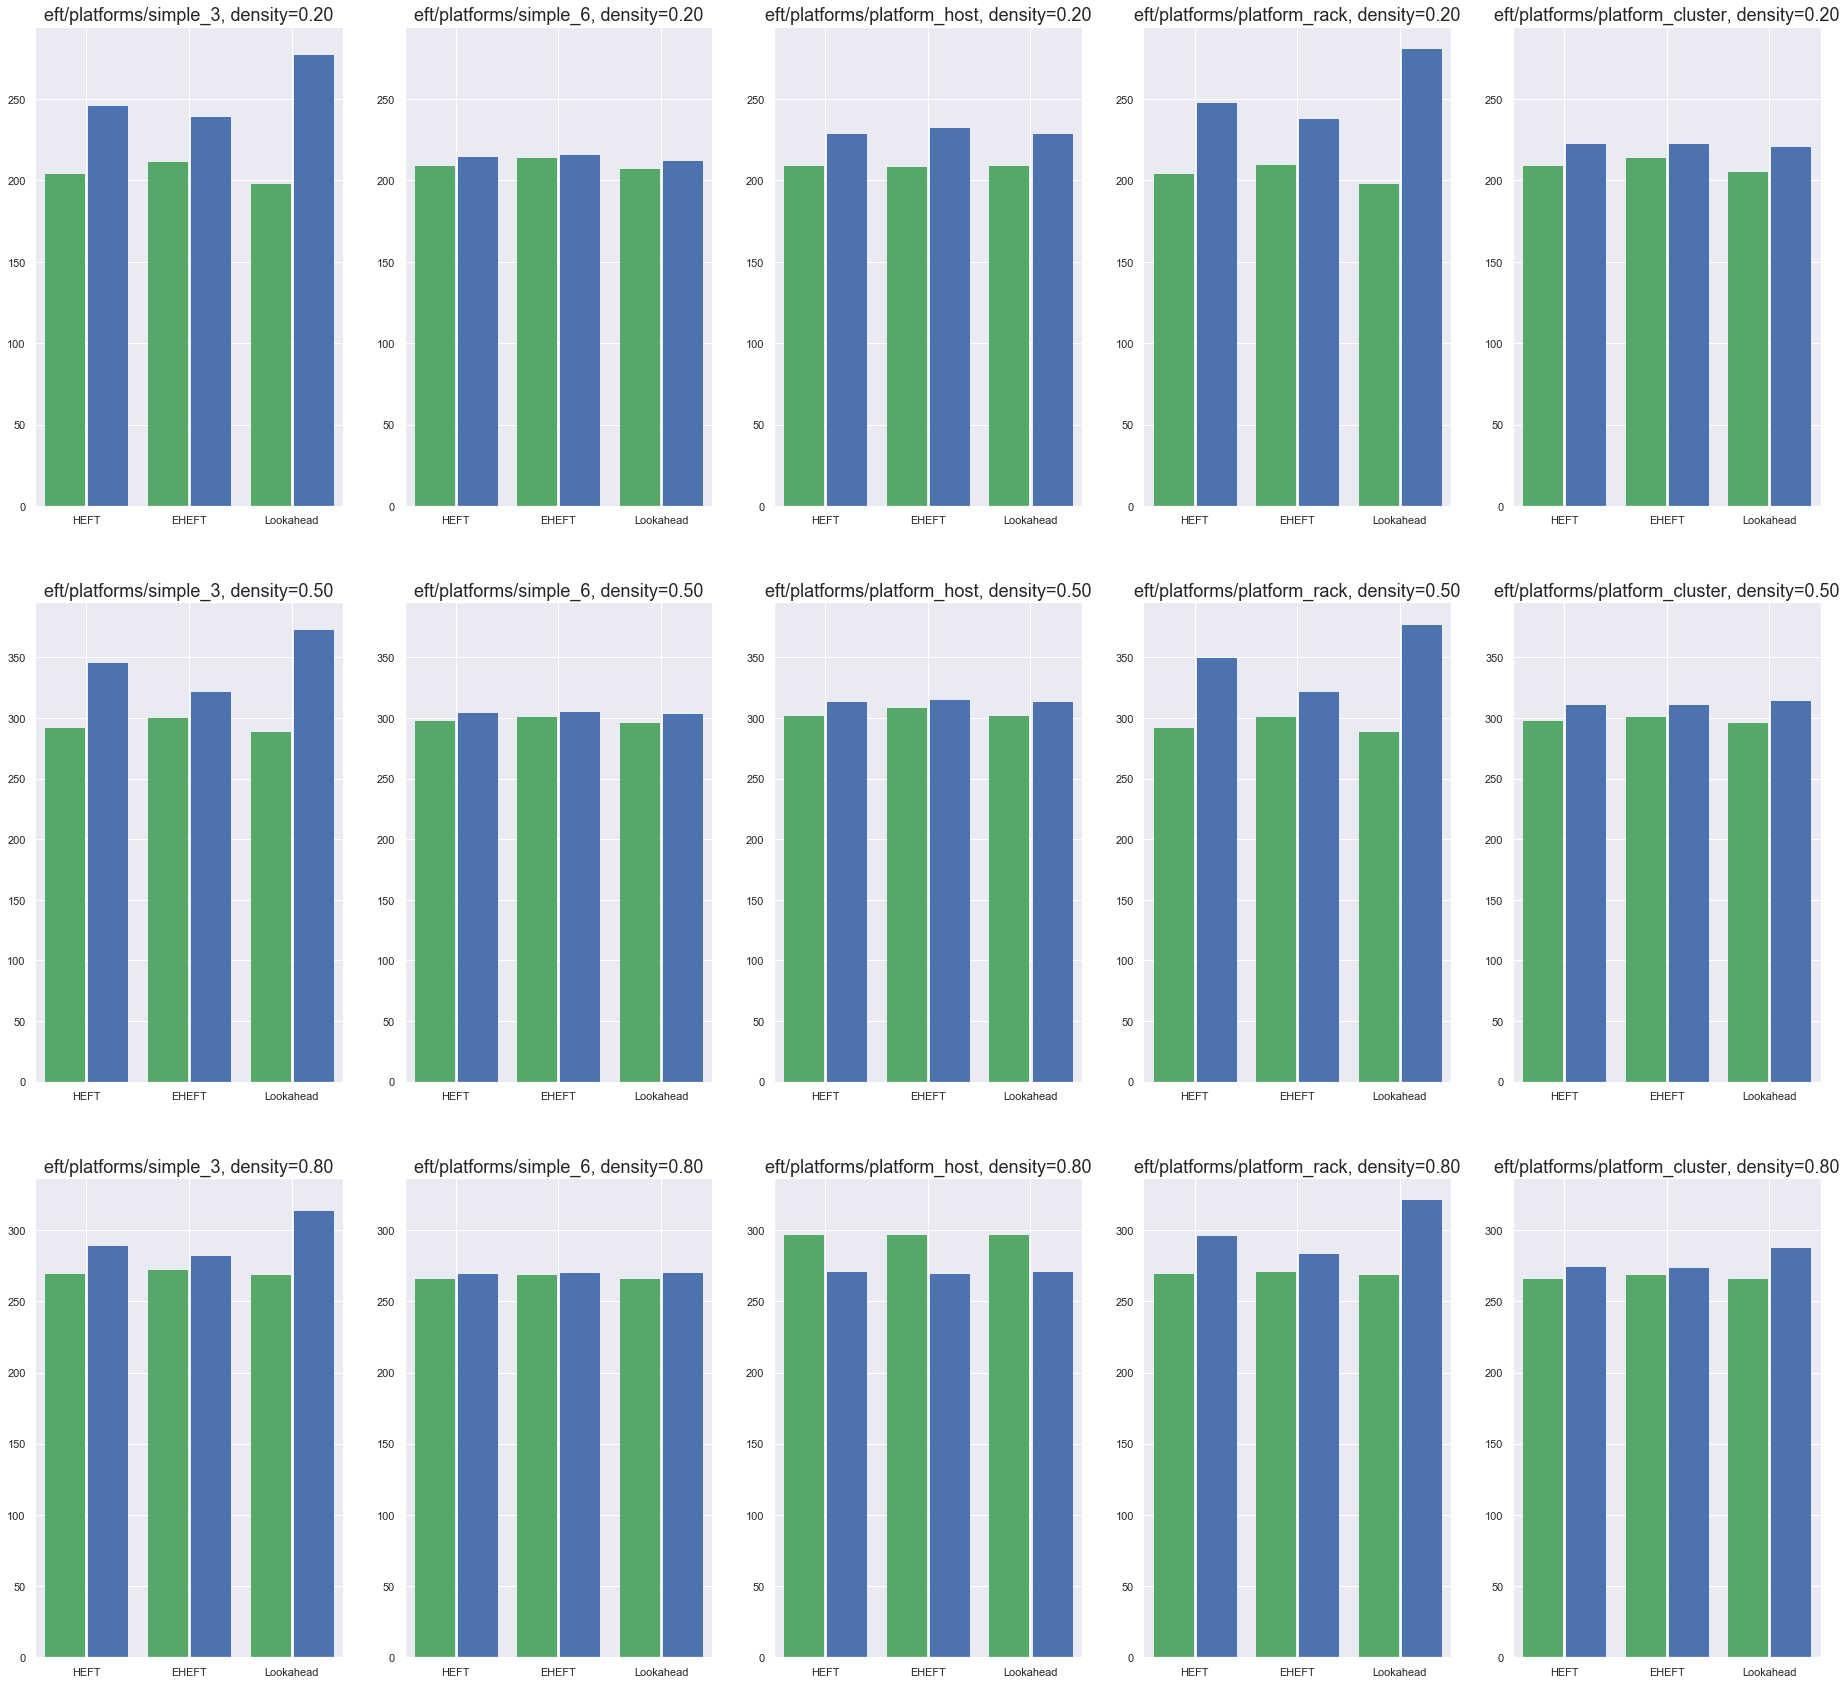

In [8]:
import json
results = json.load(open('output'))
results = [x for x in results if '../thesis/experiment-3/platforms/platforms/' not in x['platform']]
for x in results:
    x['tasks'] = x['tasks'][len('../thesis/experiment-3/workflows/'):][:-len('.dot')]
    x['platform'] = x['platform'][len('../thesis/experiment-3/platforms/'):][:-len('.xml')]
    
mean = groupby_value(results, 4)
results = list(mean.values())

by_platform_and_worflow = {}
for r in results:
    if 'simple_' in r['tasks']:
        continue
    by_platform_and_worflow.setdefault(r['tasks'], {})
    by_platform_and_worflow[r['tasks']].setdefault(r['platform'], [])
    by_platform_and_worflow[r['tasks']][r['platform']].append(r)

plt.figure(figsize=(32, 30))
counter = 1
for i, (workflow, workflow_results) in enumerate(sorted(by_platform_and_worflow.items())):
    max_res = 0
    for platform_results in workflow_results.values():
        expected = [x['expected_makespan'] for x in platform_results if not math.isnan(x['expected_makespan'])] or [max_res]
        max_res = max(
             max_res,
             max([x['makespan'] for x in platform_results]),
             max(expected)
         )
    for j, (platform, platform_results) in enumerate(sorted(workflow_results.items(), key=platform_sort_key)):
        ax = plt.subplot(len(by_platform_and_worflow), len(workflow_results), counter)
        plt.ylim(top=max_res*1.05)
        bar_chart(ax, platform_results)
        plt.title(f'{platform}, density={workflow}', fontsize=18)
        counter += 1
plt.savefig('charts.png')